In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import time
from multiprocessing import Pool
from pathlib import Path
import pathlib, pickle

from sklearn.metrics import f1_score, precision_recall_fscore_support
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.model_selection import StratifiedKFold

import sys, os
# add folder path where discrepancies folder is
#_PATH = '/Users/a435vv/OneDrive - AXA/Projects/BlackboxesDiscrepancies/discrepancies-in-machine-learning/'
#sys.path.insert(0, _PATH) 
sys.path.append(os.path.dirname(sys.path[0]))

from discrepancies import datasets, pool, pool2graph, evaluation

In [3]:
_DATASET = 'boston'
_K_INIT = 25
_K_REFINEMENT = 0
_MAX_EPOCHS = 5

X_train, X_test, y_train, y_test, scaler, feature_names, target_names = datasets.get_dataset(dataset=_DATASET, n_samples=1000, noise=0.3)

pool1 = pool.AutoSklearnPool(max_delta_accuracies=0.05, time_left_for_this_task=30, n_jobs=14)
pool1 = pool1.fit(X_train, y_train)

p2g = pool2graph.pool2graph(X_train,
                            y_train,
                            pool1,
                            k_init=_K_INIT,
                            k_refinement=_K_REFINEMENT)

p2g.fit(max_epochs=_MAX_EPOCHS)


In [35]:
from yellowbrick.classifier import PrecisionRecallCurve, ClassificationReport

def plot_PRC(model, X_train, y_train, X_test, y_test):
    # Create the visualizer, fit, score, and show it
    viz = ClassificationReport(model)
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.show()

In [66]:
#X_mc, kde_score = evaluation.random_sampling_kde(X_train, n=20000)
#X_mc = pd.DataFrame(X_mc, columns=X_train.columns)
#y_mc_pool_discr = p2g.pool.predict_discrepancies(X_mc)


X_mc = np.random.uniform(low=X_train.min(), high=X_train.max(), size=(20000,X_train.shape[1]))
y_mc_pool_discr = p2g.pool.predict_discrepancies(X_mc)

In [70]:
X_mc = pd.DataFrame(X_mc, columns=X_train.columns)

<AxesSubplot:>

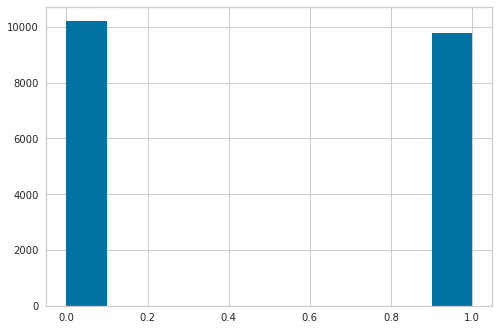

In [67]:
y_mc_pool_discr.hist()

In [73]:
components = p2g.get_discrepancies_components()

In [76]:
components.unique()

array([   1,    2,    3, ..., 1137, 1138, 1139])

In [77]:
components.nunique()

1139

In [80]:
components.shape

(21260,)

In [82]:
components[components==1].shape

(16815,)

In [42]:
X_discr, y_discr = p2g.get_discrepancies_dataset()

xgbc_p2g = xgb.XGBClassifier(n_jobs=1, verbosity=0).fit(X_discr, y_discr)
tmp = f1_score(y_mc_pool_discr, xgbc_p2g.predict(X_mc))
print(tmp)

####

X_samples, kde_score = evaluation.random_sampling_kde(X_train, n=len(X_discr))
X_samples = pd.DataFrame(X_samples, columns=X_train.columns)
y_samples_pool_discr = p2g.pool.predict_discrepancies(X_samples)

xgbc_rs = xgb.XGBClassifier(n_jobs=1, verbosity=0).fit(X_samples, y_samples_pool_discr)
tmp = f1_score(y_mc_pool_discr, xgbc_rs.predict(X_mc))
print(tmp)

0.8174327840416306
0.848613169595596
0.8617768595041322


In [55]:
X_discr_sub = X_discr.sample(frac=0.95)
tmp = X_samples[y_samples_pool_discr==0].sample(n=X_discr.shape[0]-X_discr_sub.shape[0])
X_tmp = pd.concat((X_discr_sub,tmp), axis=0)

tmp = y_samples_pool_discr.iloc[tmp.index]
y_tmp = pd.concat((y_discr.loc[X_discr_sub.index],tmp), axis=0)

xgbc_p2g_imp = xgb.XGBClassifier(n_jobs=1, verbosity=0).fit(X_tmp, y_tmp)
tmp = f1_score(y_mc_pool_discr, xgbc_p2g_imp.predict(X_mc))
print(tmp)

0.40285204991087337


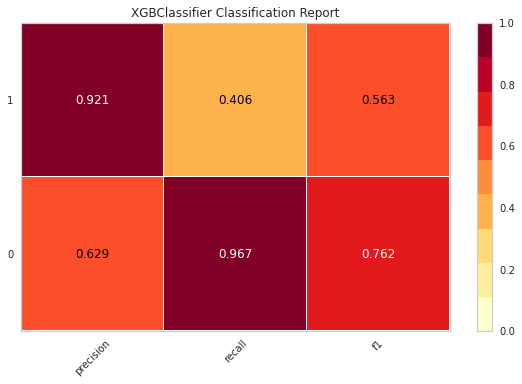

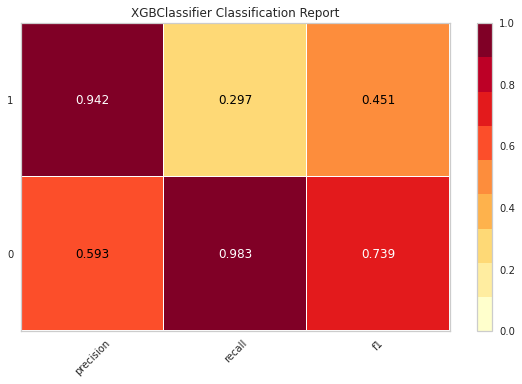

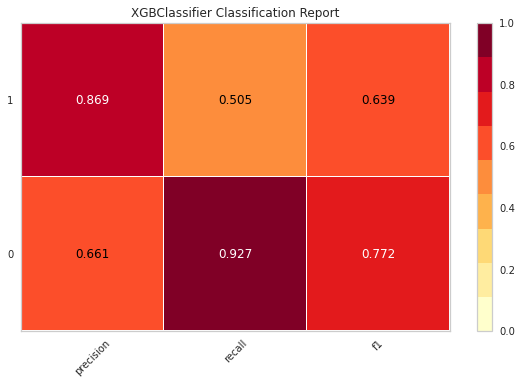

In [71]:
plot_PRC(xgbc_p2g, X_samples, y_discr, X_mc, y_mc_pool_discr)
plot_PRC(xgbc_p2g_imp, X_tmp, y_tmp, X_mc, y_mc_pool_discr)
plot_PRC(xgbc_rs, X_discr, y_samples_pool_discr, X_mc, y_mc_pool_discr)

<AxesSubplot:>

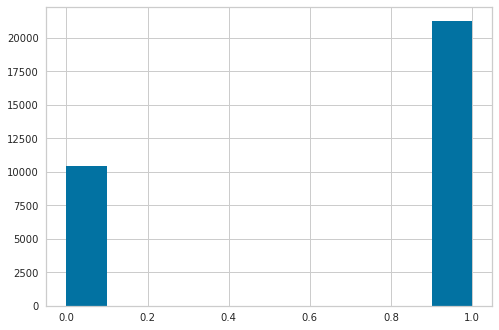

In [43]:
y_discr.hist()

<AxesSubplot:>

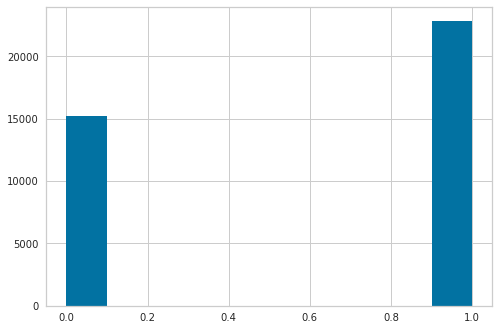

In [44]:
y_tmp.hist()

<AxesSubplot:>

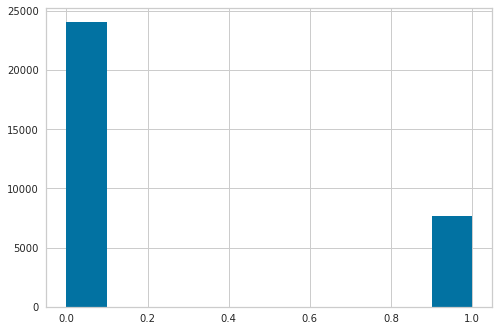

In [45]:
y_samples_pool_discr.hist()

In [ ]:
import experiment

test_fidelity(p2g, run)

In [6]:
_DATASET = 'boston'
_K_INIT = 25
_K_REFINEMENT = 0
_MAX_EPOCHS = 5

X_train, X_test, y_train, y_test, scaler, feature_names, target_names = datasets.get_dataset(dataset=_DATASET, n_samples=1000, noise=0.3)
pool1 = pool.AutoSklearnPool(max_delta_accuracies=0.05, time_left_for_this_task=30, n_jobs=14)
pool1 = pool1.fit(X_train, y_train)

In [15]:
X_samples, kde_score = evaluation.random_sampling_kde(X_train, n=10000)
X_samples = pd.DataFrame(X_samples, columns=X_train.columns)
y_samples = pool1.predict(X_samples).iloc[:,0]

In [16]:
p2g = pool2graph.pool2graph(X_samples,
                            y_samples,
                            pool1,
                            k_init=_K_INIT,
                            k_refinement=_K_REFINEMENT)

p2g.fit(max_epochs=2)

In [23]:
X_mc = np.random.uniform(low=X_train.min(), high=X_train.max(), size=(20000,X_train.shape[1]))
y_mc_pool_discr = p2g.pool.predict_discrepancies(X_mc)

X_mc = pd.DataFrame(X_mc, columns=X_train.columns)

In [24]:
X_discr, y_discr = p2g.get_discrepancies_dataset()

xgbc_p2g = xgb.XGBClassifier(n_jobs=1, verbosity=0).fit(X_discr, y_discr)
tmp = f1_score(y_mc_pool_discr, xgbc_p2g.predict(X_mc))
print(tmp)

####

X_samples, kde_score = evaluation.random_sampling_kde(X_train, n=len(X_discr))
X_samples = pd.DataFrame(X_samples, columns=X_train.columns)
y_samples_pool_discr = p2g.pool.predict_discrepancies(X_samples)

xgbc_rs = xgb.XGBClassifier(n_jobs=1, verbosity=0).fit(X_samples, y_samples_pool_discr)
tmp = f1_score(y_mc_pool_discr, xgbc_rs.predict(X_mc))
print(tmp)

0.5251299826689775
0.4751232631107127
